# Orbit for Bayesian Time Series Forecasting

Intro to the Orbit API for bayesian time series forecasting - backend is in PyStan and Pyro.

* [Orbit Docs](https://orbit-ml.readthedocs.io/en/latest/tutorials/pyro_basic.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import orbit
from orbit.models import DLT, KTR
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.dataset import load_iclaims, load_air_passengers

# from orbit.constants.palette import OrbitPalette

Dataset is monthly initial unemployment claims from 2010-2018, similar to the one from the original `bsts` paper.

In [2]:
df = load_iclaims()
df.head()

/Users/U0596854/Library/Caches/pypoetry/virtualenvs/pymc-statespace-FRV7Ufu--py3.10/lib/python3.10/site-packages/orbit/utils/dataset.py:27: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(url, parse_dates=["week"])


,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


In [3]:
response_col = 'claims'
date_col = 'week'
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]
print(df.shape)

(443, 7)


## Motivation - why Orbit?

Orbit fills a niche in my forecasting arsenal in which I wish to do Bayesian time series analysis and forecasting and use an 'out of the box' solution rather than write up my own. Along with `nixtla`'s `statforecast` solution and plain `statsmodels`, this is the beefiest hammer I plan to have in my toolbox, outside of building something bespoke.

`Orbit` also includes 'out of the box' models that fit my use case. I work entirely in small data and in a situation where interpretability and the ability to make a *generative* model with business knowledge is at a premium over pure forecasting accuracy. My business users care not just about the predictions themselves, but also of the posterior distribution of our predictions and how the results might change under different assumptions.



## Bayesian Exponential Smoothing with Damped Local Trend (DLT)

A mix between 'Error, Trend Seasonal' ETS ([Hyndman](https://otexts.com/fpp3/ets-forecasting.html)) and 'Local Global Trend' [LGT](https://cran.r-project.org/web/packages/Rlgt/index.html). Extends the $ETS(A, A_d, A)$ model with external regressors, both a local and global trend (from LGT), and a Bayesian prior for the distribution of $y_{t+1}$

* [Reference paper](https://arxiv.org/pdf/2004.08492.pdf)
* [Orbit Docs: Damped Local Trend](https://orbit-ml.readthedocs.io/en/latest/tutorials/dlt.html)



Step 1: Instantiate the model

In [4]:
dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seasonality=52,
    seed=8888,
    global_trend_option='linear',
    # for prediction uncertainty
    n_bootstrap_draws=1000,
)

If using `pyro-svi` see `orbit.estimators.pyro_estimator` for additional parameters and kwargs

Step 2: Fit the model to the data

First time running with `stan-mcmc` takes a while but it'll eventually get there. Subsequent runs get faster

In [5]:
dlt.fit(df=train_df)

2023-10-30 10:15:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Step 3: Predict

The `.predict()` method returns a dataframe with the predicted values along with a prediction interval.

In [6]:
predicted_df = dlt.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2017-07-02,12.317330,12.412867,12.513978,12.249756,12.358210,12.467011,0.022617,0.055715,0.093618,0.0,0.0,0.0
1,2017-07-09,12.441982,12.533106,12.637803,12.256808,12.358308,12.468292,0.139622,0.177879,0.210068,0.0,0.0,0.0
2,2017-07-16,12.289698,12.380969,12.481864,12.255024,12.355999,12.461829,-0.000578,0.025733,0.066563,0.0,0.0,0.0
3,2017-07-23,12.131210,12.235146,12.329359,12.242363,12.353536,12.457519,-0.145429,-0.118361,-0.077043,0.0,0.0,0.0
4,2017-07-30,12.080429,12.181359,12.281458,12.237488,12.346863,12.451393,-0.194664,-0.166493,-0.126770,0.0,0.0,0.0


Utility function `plot_predicted_data`

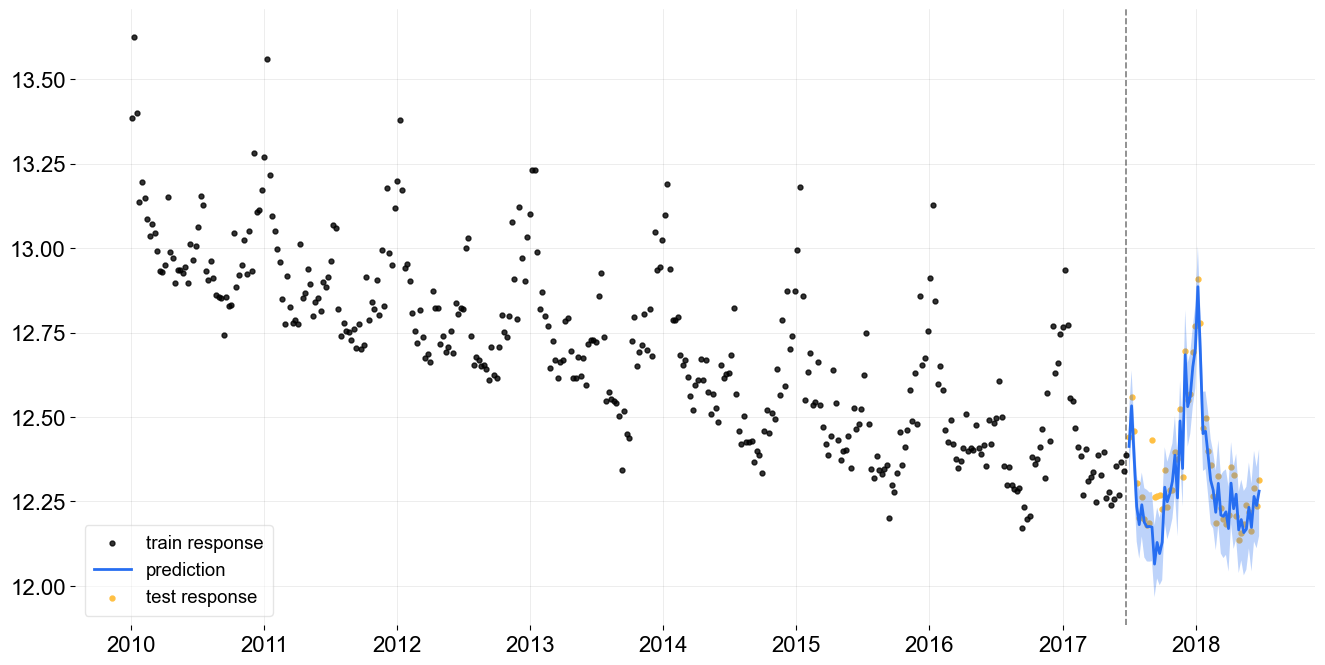

In [7]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df,
                    date_col=dlt.date_col, actual_col=dlt.response_col,
                    test_actual_df=test_df)

Utility function `plot_predicted_components` to plot the trend, seasonality, and regression components of the model

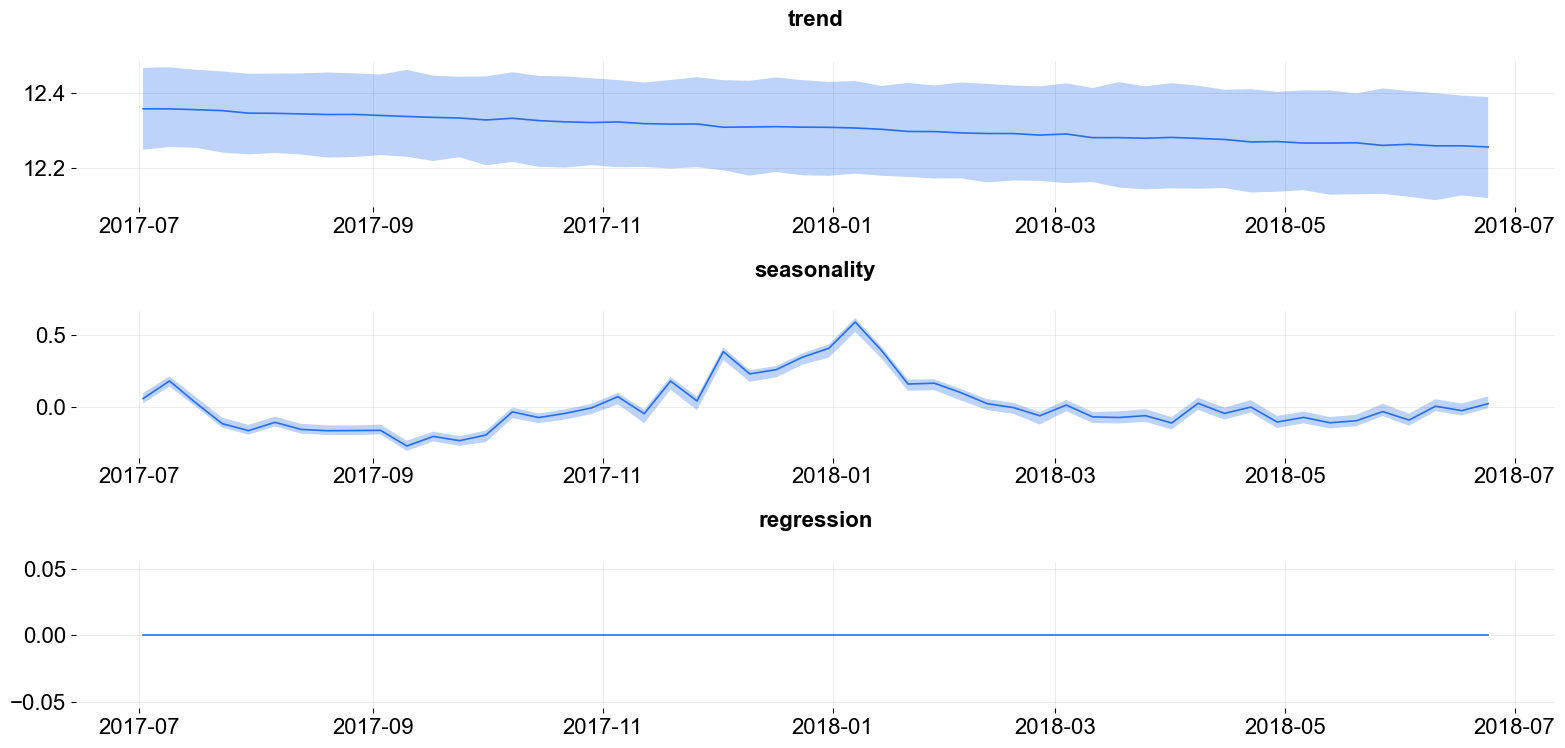

In [8]:
plot_predicted_components(predicted_df, date_col);

## Regression

We can add external regressors with `regressor_col`

2023-10-30 10:15:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

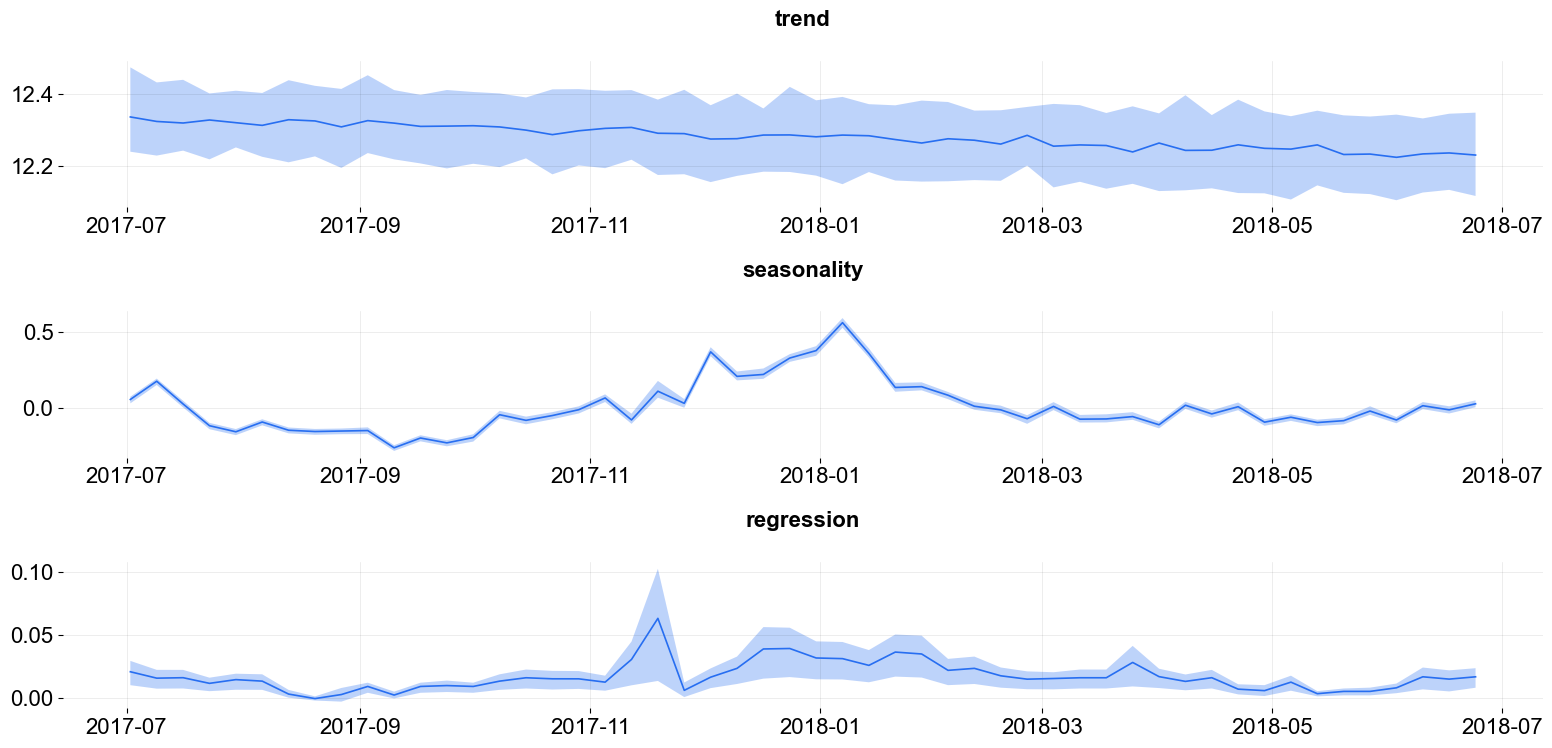

In [9]:
dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seed=8888,
    seasonality=52,
    regressor_col=['trend.unemploy', 'trend.filling'],
    regressor_beta_prior=[0.1, 0.3],
    regressor_sigma_prior=[0.5, 2.0],
)

dlt.fit(train_df)
predicted_df = dlt.predict(test_df, decompose=True)
plot_predicted_components(predicted_df, date_col);

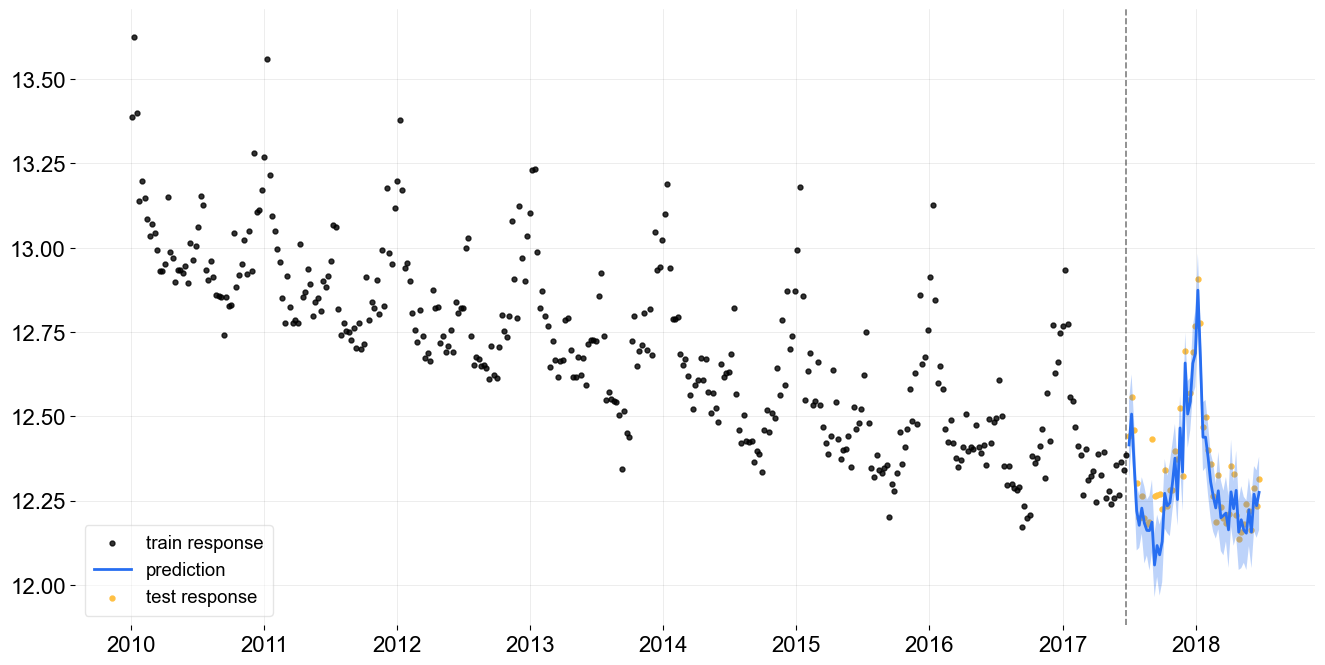

In [10]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df,
                    date_col=dlt.date_col, actual_col=dlt.response_col,
                    test_actual_df=test_df)

Get the regression coefs out with `.get_regression_coefs()`

In [11]:
dlt.get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,trend.unemploy,Regular,0.048611,0.021648,0.074990,1.0,0.0
1,trend.filling,Regular,0.098188,0.020358,0.159163,1.0,0.0


## Kernel Based Regression with Time Varying Coefficients (KTR)

One of the reasons to use Orbit is the ability to do Regression with Time-Varying coefficients using either a `Pyro` SVI backend *or* MCMC in `Stan`.

In [12]:
ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    seed=2021,
    estimator='pyro-svi',
    # bootstrap sampling to capture uncertainties
    n_bootstrap_draws=1e4,
    # pyro training config
    num_steps=301,
    message=100,
)

In [13]:
ktr.fit(train_df)

2023-10-30 10:16:00 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
2023-10-30 10:16:00 - orbit - INFO - Using SVI (Pyro) with steps: 301, samples: 100, learning rate: 0.1, learning_rate_total_decay: 1.0 and particles: 100.
2023-10-30 10:16:00 - orbit - INFO - step    0 loss = -78.124, scale = 0.096221
INFO:orbit:step    0 loss = -78.124, scale = 0.096221
2023-10-30 10:16:00 - orbit - INFO - step  100 loss = -137.7, scale = 0.042901
INFO:orbit:step  100 loss = -137.7, scale = 0.042901
2023-10-30 10:16:01 - orbit - INFO - step  200 loss = -137.84, scale = 0.042104
INFO:orbit:step  200 loss = -137.84, scale = 0.042104
2023-10-30 10:16:02 - orbit - INFO - step  300 loss = -137.48, scale = 0.042841
INFO:orbit:step  300 loss = -137.48, scale = 0.042841


In [14]:
predicted_df = ktr.predict(df=test_df)
predicted_df.head()

,week,prediction_5,prediction,prediction_95
0,2017-07-02,12.129121,12.414704,12.684076
1,2017-07-09,12.135657,12.413964,12.696453
2,2017-07-16,12.141017,12.411109,12.695155
3,2017-07-23,12.129977,12.413263,12.698044
4,2017-07-30,12.117993,12.414406,12.704660


In [15]:
ktr.get_posterior_samples().keys()

dict_keys(['lev_knot', 'lev', 'yhat', 'obs_scale'])

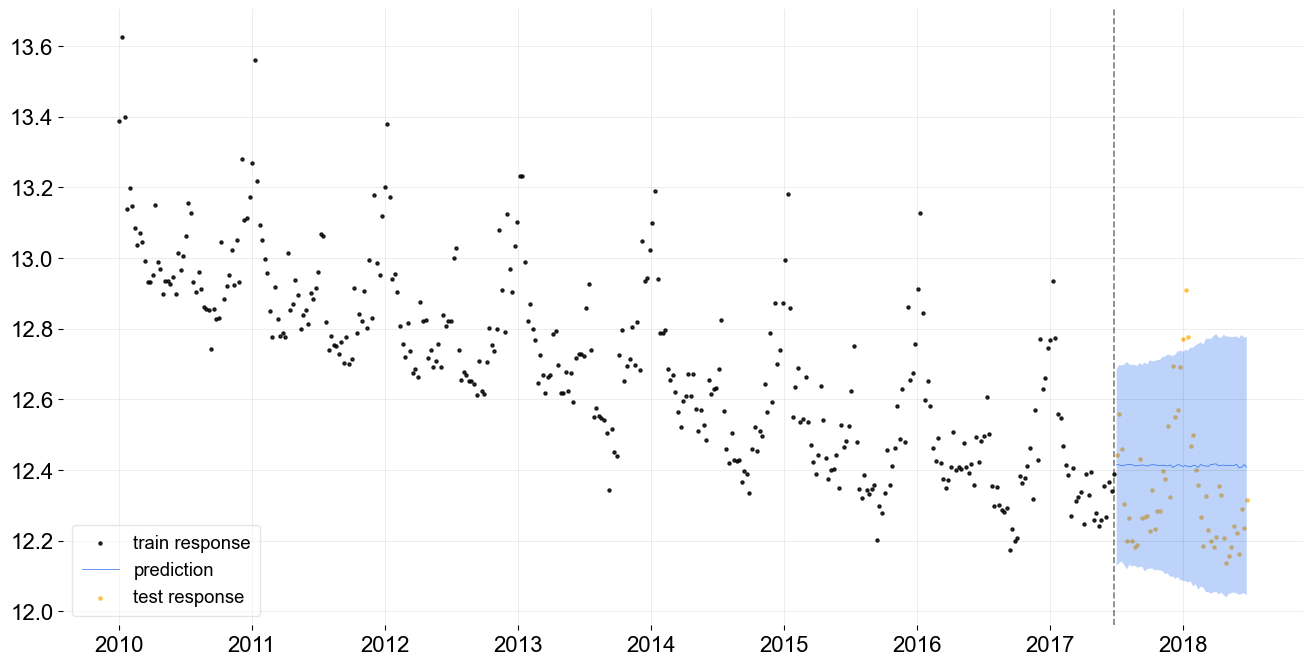

In [16]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df,
                        date_col=date_col, actual_col=response_col,
                        test_actual_df=test_df, markersize=20, lw=.5)

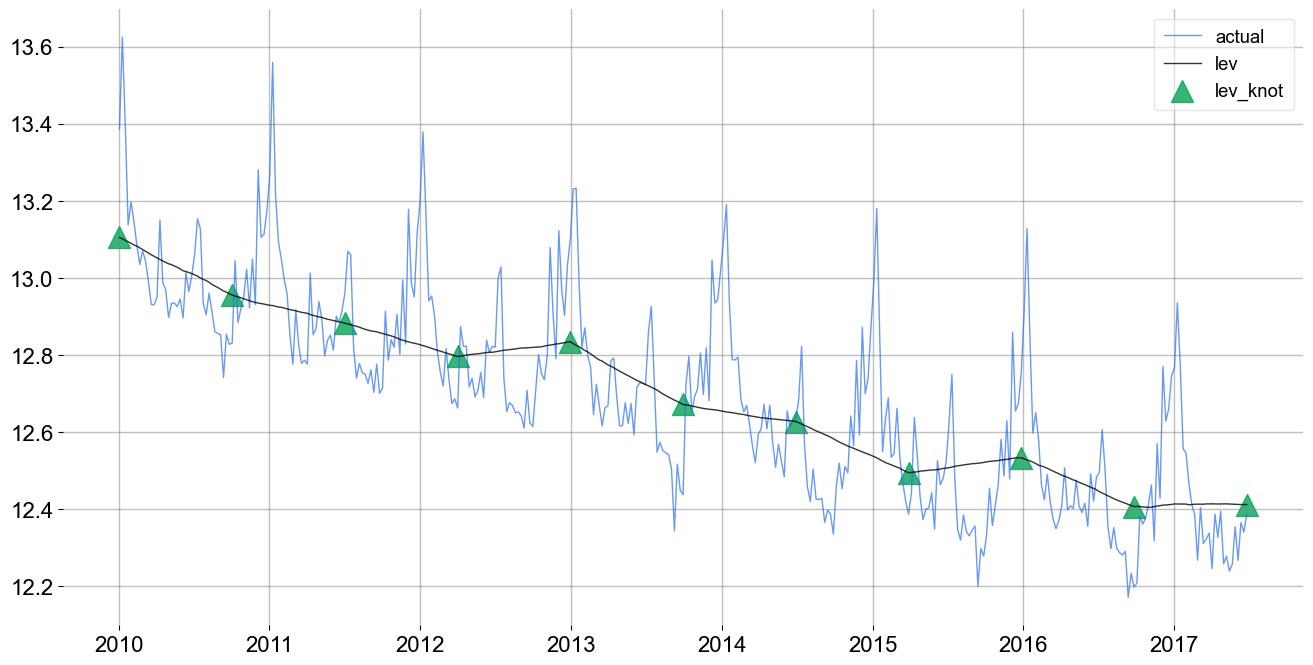

In [17]:
_ = ktr.plot_lev_knots()